In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from math import sin, cos, radians
from sklearn import linear_model
from sklearn import svm 
import torch as t



In [2]:
def rotate_point(point, angle, center_point=(0, 0)):
    """Rotates a point around center_point(origin by default)
    Angle is in degrees.
    Rotation is counter-clockwise
    """
    angle_rad = radians(angle % 360)
    # Shift the point so that center_point becomes the origin
    new_point = (point[0] - center_point[0], point[1] - center_point[1])
    new_point = (new_point[0] * cos(angle_rad) - new_point[1] * sin(angle_rad),
                 new_point[0] * sin(angle_rad) + new_point[1] * cos(angle_rad))
    # Reverse the shifting we have done
    new_point = (new_point[0] + center_point[0], new_point[1] + center_point[1])
    return np.array(new_point)

In [49]:
c1 = (1, 0)
c2 = (-1, 0)
rot = 10
n1 = np.random.normal(c1, (0.2, 1), size=(500, 2))
n2 = np.random.normal(c2, (0.2, 1), size=(500, 2))

n1 = np.array([rotate_point(n, rot, center_point=c1) for n in n1])
n2 = np.array([rotate_point(n, rot, center_point=c2) for n in n2])

y = [0]*len(n1) + [1]*len(n2)

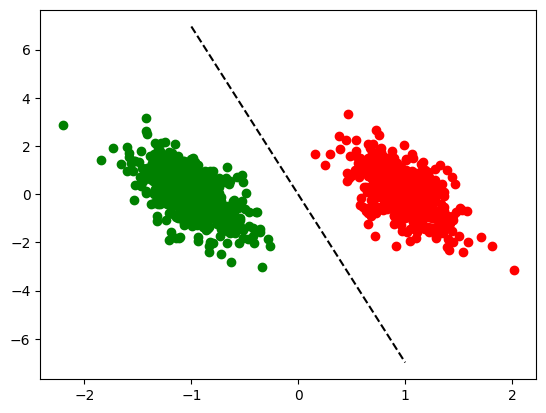

In [50]:
model = svm.SVC(kernel='linear') 
x = np.concatenate((n1, n2))
model.fit(x, y)

w = model.coef_[0] 
b = model.intercept_[0]  
absc = np.linspace(-1, 1) 
ordo = -(w[0] / w[1]) * absc - b / w[1] 
plt.plot(absc, ordo, 'k--') 

plt.scatter(n1[:, 0], n1[:, 1], c="red")
plt.scatter(n2[:, 0], n2[:, 1], c="green")

plt.show()


In [5]:
class MMProbe(t.nn.Module):
    def __init__(self, direction, covariance=None, inv=None, atol=1e-3):
        super().__init__()
        self.direction = t.nn.Parameter(direction, requires_grad=False)
        if inv is None:
            self.inv = t.nn.Parameter(t.linalg.pinv(covariance, hermitian=True, atol=atol), requires_grad=False)
        else:
            self.inv = t.nn.Parameter(inv, requires_grad=False)

    def forward(self, x, iid=False):
        if iid:
            return t.nn.Sigmoid()(x @ self.inv @ self.direction)
        else:
            return t.nn.Sigmoid()(x @ self.direction)

    def pred(self, x, iid=False):
        return self(x, iid=iid).round()

    def from_data(acts, labels, atol=1e-3, device='cpu'):
        acts, labels
        pos_acts, neg_acts = acts[labels==1], acts[labels==0]
        pos_mean, neg_mean = pos_acts.mean(0), neg_acts.mean(0)
        direction = pos_mean - neg_mean

        centered_data = t.cat([pos_acts - pos_mean, neg_acts - neg_mean], 0)
        covariance = centered_data.t() @ centered_data / acts.shape[0]
        
        probe = MMProbe(direction, covariance=covariance).to(device)

        return probe

    def fit(self, x, y):
        return self.from_data(t.tensor(x), t.tensor(y))
        
    def predict(self, x):
        return self.pred(t.tensor(np.array(x)).double())


In [18]:
p = MMProbe.from_data(t.tensor(x), t.tensor(y))
x_test = t.tensor(np.array([1, 0])).double()
p.pred(x_test)


tensor(0., dtype=torch.float64)

In [7]:
# mass mean probe
theta = np.mean(n1, axis=0) - np.mean(n2, axis=0)

print(theta)
x_test = np.array([-1, 0])
print(np.dot(theta.T, x_test))
px = scipy.stats.logistic.pdf(np.dot(theta.T, x_test))

print(px)

[0.96755335 1.28324391]
-0.9675533486335687
0.1995406623564801
